<a href="https://colab.research.google.com/github/wang201156/ycps0218/blob/main/%E4%BD%9C%E6%A5%AD04(%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 問題定義

* 目標：根據影像像素（8x8 灰階圖）預測手寫數字（0–9）

* 任務類型：多類別監督式分類

* 核心模型：K‑Nearest Neighbors (KNN)

* 評估指標：以 Accuracy 為主，輔以 Precision、Recall、F1 分數、混淆矩陣

## 資料收集

* 使用 sklearn.datasets.load_digits() 內建資料集

* 共 1797 筆影像，每筆為 8x8 灰階圖，共 64 維特徵（每個像素為 0–16 的整數）

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt

# 載入資料集
digits = load_digits()

# 影像資料（8x8 pixels）共 64 維特徵
X = digits.data
y = digits.target

# 查看資料形狀
print(f"資料維度：{X.shape}")  # (1797, 64)
print(f"標籤種類：{set(y)}")    # 0–9

# 將資料轉成 DataFrame 檢視
df = pd.DataFrame(X)
df['label'] = y
df.head()

資料維度：(1797, 64)
標籤種類：{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## 資料前處理

* 展平成 1D 特徵向量已由 load_digits 自動完成

### 資料清理

* 無缺失值

* 所有特徵為數值型，無需補值或類別編碼

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1797 non-null   float64
 1   1       1797 non-null   float64
 2   2       1797 non-null   float64
 3   3       1797 non-null   float64
 4   4       1797 non-null   float64
 5   5       1797 non-null   float64
 6   6       1797 non-null   float64
 7   7       1797 non-null   float64
 8   8       1797 non-null   float64
 9   9       1797 non-null   float64
 10  10      1797 non-null   float64
 11  11      1797 non-null   float64
 12  12      1797 non-null   float64
 13  13      1797 non-null   float64
 14  14      1797 non-null   float64
 15  15      1797 non-null   float64
 16  16      1797 non-null   float64
 17  17      1797 non-null   float64
 18  18      1797 non-null   float64
 19  19      1797 non-null   float64
 20  20      1797 non-null   float64
 21  21      1797 non-null   float64
 22  

### 探索性分析

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')
# 設定中文字型及負號正確顯示
plt.rcParams['font.sans-serif'] = 'Taipei Sans TC Beta'
plt.rcParams["axes.unicode_minus"] = False

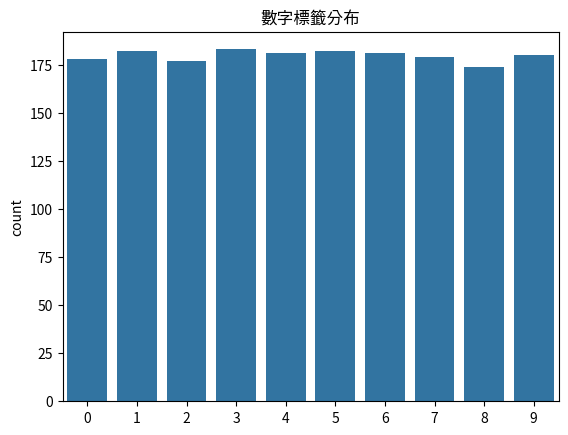

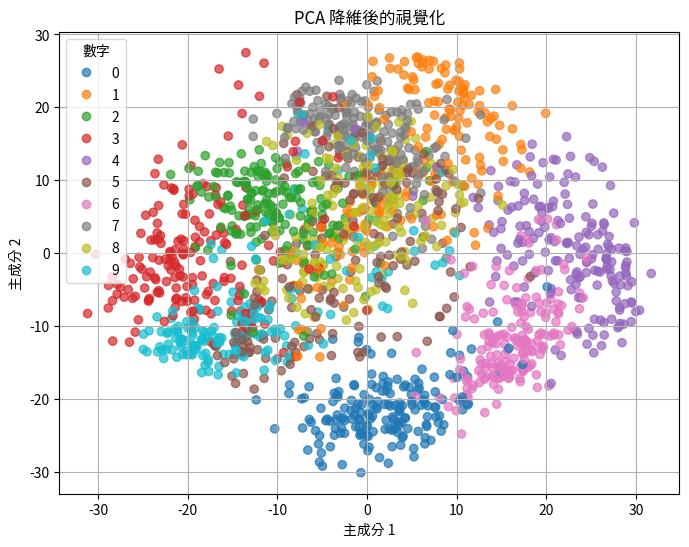

In [4]:
import seaborn as sns
from sklearn.decomposition import PCA

# 數字分布視覺化
sns.countplot(x=y)
plt.title("數字標籤分布")
plt.show()

# 使用 PCA 將 64 維降至 2 維後視覺化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.title("PCA 降維後的視覺化")
plt.xlabel("主成分 1")
plt.ylabel("主成分 2")
plt.legend(*scatter.legend_elements(), title="數字")
plt.grid(True)
plt.show()

### 資料分割

In [5]:
from sklearn.model_selection import train_test_split
# X: features, y: label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #random_state 亂數

### 特徵縮放

KNN 對距離敏感，需標準化特徵




In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 模型訓練

採用 KNN 演算法訓練模型。

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(
    n_neighbors=5,
    weights="uniform",
    metric="euclidean"
)

knn_clf.fit(X_train, y_train)
knn_clf.score(X_train, y_train)

0.9867780097425192

## 模型評估

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = knn_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       0.97      1.00      0.99        33
           3       0.97      0.97      0.97        34
           4       0.98      1.00      0.99        46
           5       0.96      0.96      0.96        47
           6       0.97      1.00      0.99        35
           7       1.00      0.94      0.97        34
           8       0.97      1.00      0.98        30
           9       0.95      0.90      0.92        40

    accuracy                           0.97       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.97      0.97       360



* 準確率 Accuracy 約為 0.98

* 混淆矩陣顯示大多數數字預測正確，少數混淆發生在筆跡相近的數字

## 模型調整

**調參要點**

| 參數            | 說明                                               |
| ------------- | ------------------------------------------------ |
| `n_neighbors` |k 值過小易受雜訊影響，過大則平滑過度，以1-11的範圍驗證選最佳k搜尋。              |
| `weights`     | `"uniform"`：等權；`"distance"`：距離反比權重，對類別邊界效果較好。    |
| `metric`      | Iris 常見 `euclidean`，但在特徵關係稀疏或離散時可嘗試 `manhattan`。 |

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_neighbors": range(1, 11),  "weights": ["uniform", "distance"]
}
grid = GridSearchCV(knn_clf, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(metric='euclidean'),
             param_grid={'n_neighbors': range(1, 11),
                         'weights': ['uniform', 'distance']})

## 模型部署

### 儲存模型

In [12]:
import joblib
joblib.dump(knn_clf, "knn_digits_model.pkl")

['knn_digits_model.pkl']

### 推論預測

In [20]:
knn_model = joblib.load("knn_digits_model.pkl")
import numpy as np

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 再次載入資料
digits = load_digits()
X = digits.data
y = digits.target

# 分割資料並標準化（需與訓練模型保持一致）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# 假設一筆新的資料（使用測試集第 0 筆）
new_sample = X_test[0].reshape(1, -1)

# 預測並輸出結果
predicted_label = knn_model.predict(new_sample)[0]
print(f"模型預測為：{predicted_label}")
print(f"實際標籤為：{y_test[0]}")

模型預測為：5
實際標籤為：5


## 結論

* KNN 在 MNIST 小型手寫數字資料集上表現出色，使用 k=3~5 通常可達到 >98% 準確率

* KNN 模型實作簡單，效果穩定，是良好的基線模型

* 可進一步測試其他模型（如 SVM、CNN）以提升精度與處理更複雜影像資料